In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import task_complexity
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class AddGaussianNoise(object):
    def __init__(self, mean = 0, std = 1.):
        self.std = std
        self.mean = mean
    
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size())*self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [3]:
class Net_CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x

In [4]:
criterion = nn.CrossEntropyLoss(reduction = "none")

In [5]:
noise_levels = [1e-9, 1e-6, 1e-3, 1e0, 1e3, 1e6, 1e9]
mi_values = []
for noise_level in noise_levels:
    print(f"Noise Level: {noise_level}")
    transform = transforms.Compose([
        transforms.ToTensor(),
        AddGaussianNoise(0., noise_level),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    target_transform_cifar10 = transforms.Compose([
        lambda x: torch.tensor(x),
        lambda x: F.one_hot(x, num_classes = 10)
        ])
    
    batch_size = 16

    trainset_cifar10 = CIFAR10(root = '../example_data/', train = True, transform = transform, target_transform = target_transform_cifar10, download = True)
    trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size = batch_size, shuffle = True, num_workers = 2)
    
    example_set = next(iter(trainloader_cifar10))[0]
    grid = torchvision.utils.make_grid(example_set, nrow = 4)
    torchvision.utils.save_image(grid, f"example_noisy_cifar10_exponential/cifar10_images_std_{noise_level}.png")

    mi_score = task_complexity.compute_complexity(Net_CIFAR10, 10, trainloader_cifar10, criterion, n_bins = 100)
    print(f"MI Score: {mi_score}")
    mi_values.append(mi_score)

Noise Level: 1e-09
Files already downloaded and verified


/tmp/ipykernel_45448/1150912648.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


MI Score: 0.018465127108335366
Noise Level: 1e-06
Files already downloaded and verified
MI Score: 0.014009915677556606
Noise Level: 0.001
Files already downloaded and verified
MI Score: 0.016266981495696164
Noise Level: 1.0
Files already downloaded and verified
MI Score: 0.005254474265834919
Noise Level: 1000.0
Files already downloaded and verified
MI Score: 0.0010187171148253737
Noise Level: 1000000.0
Files already downloaded and verified
MI Score: 3.1663605221443625e-05
Noise Level: 1000000000.0
Files already downloaded and verified
MI Score: 9.693570947211239e-06


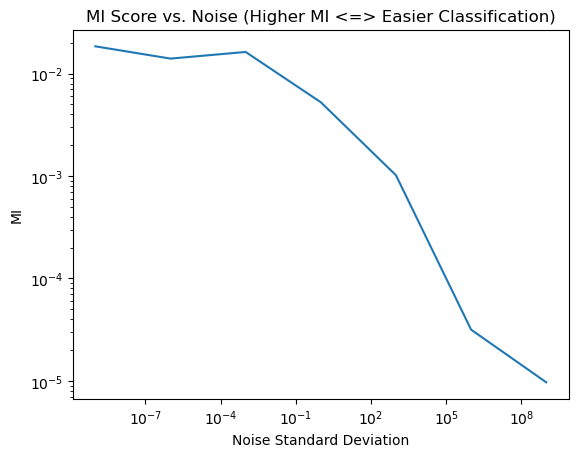

<Figure size 640x480 with 0 Axes>

In [6]:
plt.plot(noise_levels, mi_values)
plt.title("MI Score vs. Noise (Higher MI <=> Easier Classification)")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Noise Standard Deviation")
plt.ylabel("MI")
plt.show()
plt.savefig("figures/noise_effect.png")